# Streetcar Delay Prediction - Data Exploration

Use dataset covering Toronto Transit Commission (TTC) streetcar delays 2014 - 2020 to predict future delays and come up with recommendations for avoiding delays.

Source dataset: : https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da

This notebook contains additional data exploration code.

# Streetcar routes

From https://www.ttc.ca/Routes/Streetcars.jsp

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcar%20routes.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Streetcar vehicle IDs CLRV/ALRV

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarCLRV.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Streetcar vehicle IDs Flexity

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarflexity.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

In [1]:
# load the valid list of TTC Streetcar routes
valid_routes = ['501','502','503','504','505','506','509','510','511','512','301','304','306','310']

In [2]:
valid_routes

['501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '509',
 '510',
 '511',
 '512',
 '301',
 '304',
 '306',
 '310']

In [3]:
valid_directions = ['E/B','W/B','N/B','S/B']

In [4]:
valid_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

In [5]:
! pwd

/storage/manning/notebooks


# Load Data
- load pickled dataframe containing data loaded from source XLS files

In [6]:
! pip install statsmodels

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import statsmodels.api as sm
import statsmodels as sm
import seaborn as sns
import datetime
import os


In [8]:
# data is in a directory called "data" that is a sibling to the directory containing the notebook
# this code assumes you have copied to this directory all the XLS files from the source dataset: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da
rawpath = os.getcwd()
print("raw path is",rawpath)
path = os.path.abspath(os.path.join(rawpath, '..', 'data')) + "/"
print("path is", path)

raw path is /storage/manning/notebooks
path is /storage/manning/data/


In [9]:
# pickled_dataframe = '20142018_df.pkl'
pickled_input_dataframe = '2014_2018.pkl'



In [10]:
def define_feature_categories(df):
    allcols = list(df)
    print("all cols",allcols)
    textcols = ['Incident','Location'] # 
    continuouscols = ['Min Delay','Min Gap'] 
                      # columns to deal with as continuous values - no embeddings
    timecols = ['Report Date','Time']
    collist = ['Day','Vehicle','Route','Direction']
    for col in continuouscols:
        df[col] = df[col].astype(float)
    print('texcols: ',textcols)
    print('continuouscols: ',continuouscols)
    print('timecols: ',timecols)
    print('collist: ',collist)
    return(allcols,textcols,continuouscols,timecols,collist)

In [11]:
def fill_missing(dataset):
    print("before mv")
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)

# Load dataframe and add columns for time series manipulation
- load pickled dataframe
- show info about the dataset
- build index combining date+time along with labelled column date+time


In [12]:
# load pickled dataframe
df = pd.read_pickle(path+pickled_input_dataframe)

In [13]:
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2016-01-01,505,00:00:00,Friday,Dundas West stnt to Broadview stn,General Delay,7.0,14.0,W/B,4028.0
1,2016-01-01,511,02:14:00,Friday,Fleet St. and Strachan Ave.,Mechanical,10.0,20.0,E/B,4018.0
2,2016-01-01,301,02:22:00,Friday,Queen St. West and Roncesvalles Ave.,Mechanical,9.0,18.0,W/B,4201.0
3,2016-01-01,301,03:28:00,Friday,Lake Shore Blvd. and Superior St.,Mechanical,20.0,40.0,E/B,4251.0
4,2016-01-01,501,14:28:00,Friday,Roncy to Neville Park,Mechanical,6.0,12.0,E/B,4242.0


In [14]:
# ensure Route and Vehicle are strings, not numeric
# df = df.astype({"Route": str, "Vehicle": int})
df['Route'] = df['Route'].astype(str)
df['Vehicle'] = df['Vehicle'].astype(str)
# df['filename'] = df['filename'].str[:-4]
df['Vehicle'] = df['Vehicle'].str[:-2]

In [15]:
# define categories
allcols,textcols,continuouscols,timecols,collist = define_feature_categories(df) 

all cols ['Report Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Direction', 'Vehicle']
texcols:  ['Incident', 'Location']
continuouscols:  ['Min Delay', 'Min Gap']
timecols:  ['Report Date', 'Time']
collist:  ['Day', 'Vehicle', 'Route', 'Direction']


In [16]:
# fill in missing values
df = fill_missing(df)

before mv


In [17]:
# getting some information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69603 entries, 0 to 873
Data columns (total 10 columns):
Report Date    69603 non-null datetime64[ns]
Route          69603 non-null object
Time           69603 non-null object
Day            69603 non-null object
Location       69603 non-null object
Incident       69603 non-null object
Min Delay      69603 non-null float64
Min Gap        69603 non-null float64
Direction      69603 non-null object
Vehicle        69603 non-null object
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 5.8+ MB


In [18]:
# getting some information about dataset
df.shape

(69603, 10)

In [19]:
# further Analysis 
df.describe()

,Min Delay,Min Gap
count,69603.000000,69603.000000
mean,12.687672,18.127926
std,29.772404,33.610537
min,0.000000,0.000000
25%,5.000000,9.000000
50%,6.000000,12.000000
75%,12.000000,20.000000
max,1400.000000,4216.000000


In [20]:
df.dtypes

Report Date    datetime64[ns]
Route                  object
Time                   object
Day                    object
Location               object
Incident               object
Min Delay             float64
Min Gap               float64
Direction              object
Vehicle                object
dtype: object

In [21]:
# create new column combing date + time (needed for resampling) and make it the index

df['Report Date Time'] = pd.to_datetime(df['Report Date'].astype(str) + ' ' + df['Time'].astype(str))
df.index = df['Report Date Time']
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,505,00:00:00,Friday,Dundas West stnt to Broadview stn,General Delay,7.0,14.0,W/B,4028,2016-01-01 00:00:00
2016-01-01 02:14:00,2016-01-01,511,02:14:00,Friday,Fleet St. and Strachan Ave.,Mechanical,10.0,20.0,E/B,4018,2016-01-01 02:14:00
2016-01-01 02:22:00,2016-01-01,301,02:22:00,Friday,Queen St. West and Roncesvalles Ave.,Mechanical,9.0,18.0,W/B,4201,2016-01-01 02:22:00
2016-01-01 03:28:00,2016-01-01,301,03:28:00,Friday,Lake Shore Blvd. and Superior St.,Mechanical,20.0,40.0,E/B,4251,2016-01-01 03:28:00
2016-01-01 14:28:00,2016-01-01,501,14:28:00,Friday,Roncy to Neville Park,Mechanical,6.0,12.0,E/B,4242,2016-01-01 14:28:00


# Create dataframes for delay-duration based forecasting
- create a dataframe with just index and delay
- resample to get mean by month in year

In [22]:
# new = old[['A', 'C', 'D']].copy()
# new dataframe with just Min Delay column
dfstrip = df[['Min Delay']].copy()
dfstrip.head()

,Min Delay
Report Date Time,
2016-01-01 00:00:00,7.0
2016-01-01 02:14:00,10.0
2016-01-01 02:22:00,9.0
2016-01-01 03:28:00,20.0
2016-01-01 14:28:00,6.0


In [23]:
dfmonthav = dfstrip.resample('M').mean()
dfmonthav.head()

,Min Delay
Report Date Time,
2014-01-31,7.862069
2014-02-28,14.117978
2014-03-31,12.580595
2014-04-30,12.624365
2014-05-31,12.280083


In [24]:
# df3['new'] = df3.index
dfmonthav['Report Date Time'] = dfmonthav.index

In [25]:
dfmonthav.tail()

,Min Delay,Report Date Time
Report Date Time,,
2018-10-31,11.875000,2018-10-31
2018-11-30,12.415046,2018-11-30
2018-12-31,13.820569,2018-12-31
2019-01-31,12.309718,2019-01-31
2019-02-28,13.105495,2019-02-28


# Create dataframe for delay count based forecasting


In [26]:
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,505,00:00:00,Friday,Dundas West stnt to Broadview stn,General Delay,7.0,14.0,W/B,4028,2016-01-01 00:00:00
2016-01-01 02:14:00,2016-01-01,511,02:14:00,Friday,Fleet St. and Strachan Ave.,Mechanical,10.0,20.0,E/B,4018,2016-01-01 02:14:00
2016-01-01 02:22:00,2016-01-01,301,02:22:00,Friday,Queen St. West and Roncesvalles Ave.,Mechanical,9.0,18.0,W/B,4201,2016-01-01 02:22:00
2016-01-01 03:28:00,2016-01-01,301,03:28:00,Friday,Lake Shore Blvd. and Superior St.,Mechanical,20.0,40.0,E/B,4251,2016-01-01 03:28:00
2016-01-01 14:28:00,2016-01-01,501,14:28:00,Friday,Roncy to Neville Park,Mechanical,6.0,12.0,E/B,4242,2016-01-01 14:28:00


In [27]:
dfstrip.head()

,Min Delay
Report Date Time,
2016-01-01 00:00:00,7.0
2016-01-01 02:14:00,10.0
2016-01-01 02:22:00,9.0
2016-01-01 03:28:00,20.0
2016-01-01 14:28:00,6.0


In [28]:
dfmonthcount = dfstrip.resample('M').count()
# df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
dfmonthcount = dfmonthcount.rename(columns={'Min Delay':'Delay Count'})
dfmonthcount.head()

,Delay Count
Report Date Time,
2014-01-31,319
2014-02-28,178
2014-03-31,1278
2014-04-30,1182
2014-05-31,964


In [29]:
dfmonthcount['Report Date Time'] = dfmonthcount.index
dfmonthcount.head()

,Delay Count,Report Date Time
Report Date Time,,
2014-01-31,319,2014-01-31
2014-02-28,178,2014-02-28
2014-03-31,1278,2014-03-31
2014-04-30,1182,2014-04-30
2014-05-31,964,2014-05-31


In [30]:
# merged_data = merged_data.join(dm_cases.set_index('CASE_NUMBER'), on = 'CASE_NUMBER')
dfmonthav = dfmonthav.join(dfmonthcount, on='Report Date Time',lsuffix='_left', rsuffix='_right')
dfmonthav.head()

/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'Report Date Time' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)


,Min Delay,Report Date Time_left,Delay Count,Report Date Time_right
Report Date Time,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28
2014-03-31,12.580595,2014-03-31,1278,2014-03-31
2014-04-30,12.624365,2014-04-30,1182,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31


In [31]:
dfmonthav.head()

,Min Delay,Report Date Time_left,Delay Count,Report Date Time_right
Report Date Time,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28
2014-03-31,12.580595,2014-03-31,1278,2014-03-31
2014-04-30,12.624365,2014-04-30,1182,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31


In [32]:
dfmonthav = dfmonthav.rename(columns={'Report Date Time_left':'Report Date Time'})
dfmonthav.drop(['Report Date Time_right'],axis=1)
dfmonthav.head()

,Min Delay,Report Date Time,Delay Count,Report Date Time_right
Report Date Time,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28
2014-03-31,12.580595,2014-03-31,1278,2014-03-31
2014-04-30,12.624365,2014-04-30,1182,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31


In [33]:
dfmonthav.drop(['Report Date Time_right'],axis=1)
dfmonthav.head()

,Min Delay,Report Date Time,Delay Count,Report Date Time_right
Report Date Time,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28
2014-03-31,12.580595,2014-03-31,1278,2014-03-31
2014-04-30,12.624365,2014-04-30,1182,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31


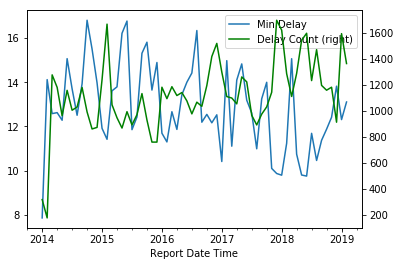

In [34]:
dfmonthav['Min Delay'].plot(legend=True)
# df.B.plot(secondary_y=True, style='g')
dfmonthav['Delay Count'].plot(secondary_y=True, style='g',legend=True)

In [35]:
#ax.set_ylabel('Average Delay')
#ax.right_ax.set_ylabel('Number of delays')
plt.rcParams["figure.figsize"] = [8,4]
plt.show()

# Time Series Forecasting
**Trend** - Trend shows the variation in the output as time increases, often in a non-linear fashion. 

**Level** - The baseline value for a time series.

**Seasonality** - is a characteristic of a time series in which the data experiences regular and predictable changes that recur every calendar year. Any predictable fluctuation or pattern that recurs or repeats over a one-year period is said to be seasonal - from https://www.investopedia.com/terms/s/seasonality.asp

**Noise** - Random variation in the data.

In [36]:
dfmonthav.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2014-01-31 to 2019-02-28
Freq: M
Data columns (total 4 columns):
Min Delay                 62 non-null float64
Report Date Time          62 non-null datetime64[ns]
Delay Count               62 non-null int64
Report Date Time_right    62 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 2.4 KB


In [37]:
# add a column to make scatter plot by month convenient
dfmonthav['Month'] = dfmonthav['Report Date Time'].dt.month
dfmonthav.head(20)

,Min Delay,Report Date Time,Delay Count,Report Date Time_right,Month
Report Date Time,,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31,1
2014-02-28,14.117978,2014-02-28,178,2014-02-28,2
2014-03-31,12.580595,2014-03-31,1278,2014-03-31,3
2014-04-30,12.624365,2014-04-30,1182,2014-04-30,4
2014-05-31,12.280083,2014-05-31,964,2014-05-31,5
2014-06-30,15.066437,2014-06-30,1159,2014-06-30,6
2014-07-31,13.701789,2014-07-31,1006,2014-07-31,7
2014-08-31,12.505335,2014-08-31,1031,2014-08-31,8
2014-09-30,13.930567,2014-09-30,1181,2014-09-30,9


In [38]:
dfmonthav.head(20)

,Min Delay,Report Date Time,Delay Count,Report Date Time_right,Month
Report Date Time,,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31,1
2014-02-28,14.117978,2014-02-28,178,2014-02-28,2
2014-03-31,12.580595,2014-03-31,1278,2014-03-31,3
2014-04-30,12.624365,2014-04-30,1182,2014-04-30,4
2014-05-31,12.280083,2014-05-31,964,2014-05-31,5
2014-06-30,15.066437,2014-06-30,1159,2014-06-30,6
2014-07-31,13.701789,2014-07-31,1006,2014-07-31,7
2014-08-31,12.505335,2014-08-31,1031,2014-08-31,8
2014-09-30,13.930567,2014-09-30,1181,2014-09-30,9


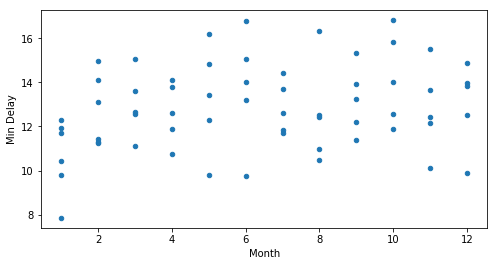

In [39]:
# scatter plot to show mean delay in same month across years
dfmonthav.plot.scatter(x = 'Month', y = 'Min Delay')
plt.show()

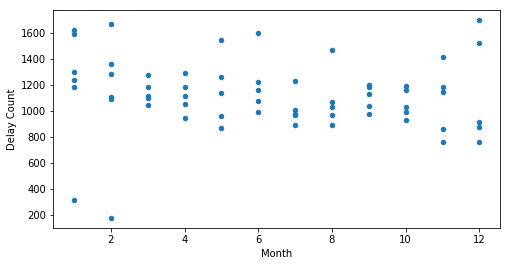

In [40]:
# scatter plot to show delay count in same month across years
dfmonthav.plot.scatter(x = 'Month', y = 'Delay Count')
plt.show()

# Trend Analysis

Use the built-in Pandas rolling function to smooth the data.

For trend analysis, we use smoothing techniques. 
- In statistics smoothing a data set means to create an approximating function that attempts to capture important patterns in the data, while leaving out noise or other fine-scale structures/rapid phenomena. 
- In smoothing, the data points of a signal are modified so individual points (presumably because of noise) are reduced, and points that are lower than the adjacent points are increased leading to a smoother signal. 

We implement smoothing by taking moving averages. [Exponential moving average](https://www.investopedia.com/terms/e/ema.asp) is frequently used to compute smoothed function.

In [41]:
mean_delay = dfmonthav[['Min Delay']]
count_delay = dfmonthav[['Delay Count']]

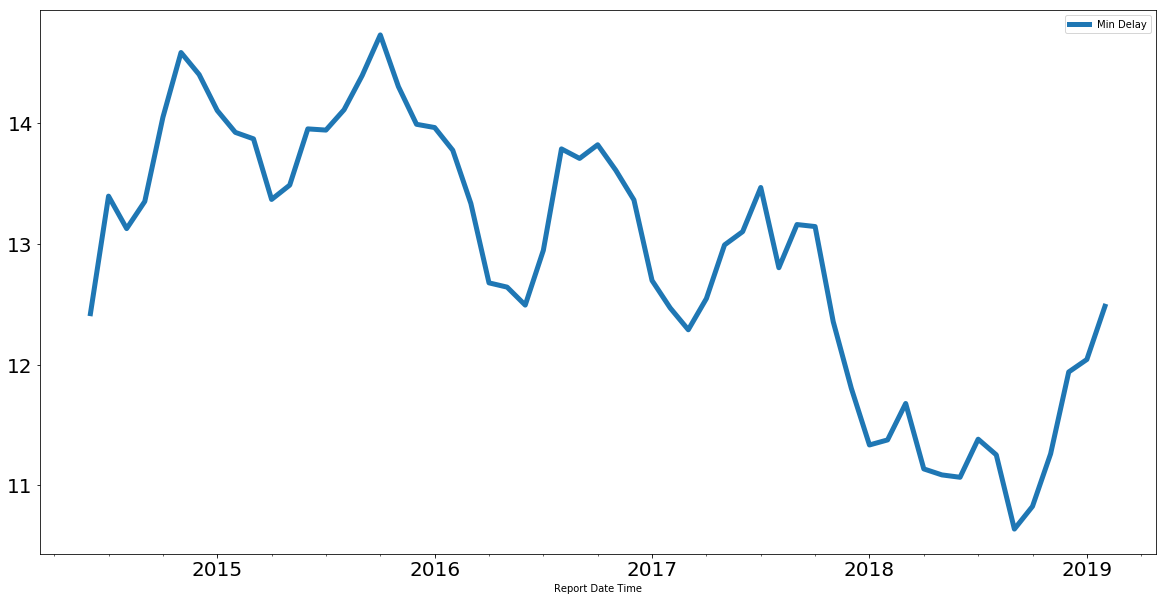

In [42]:
mean_delay.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

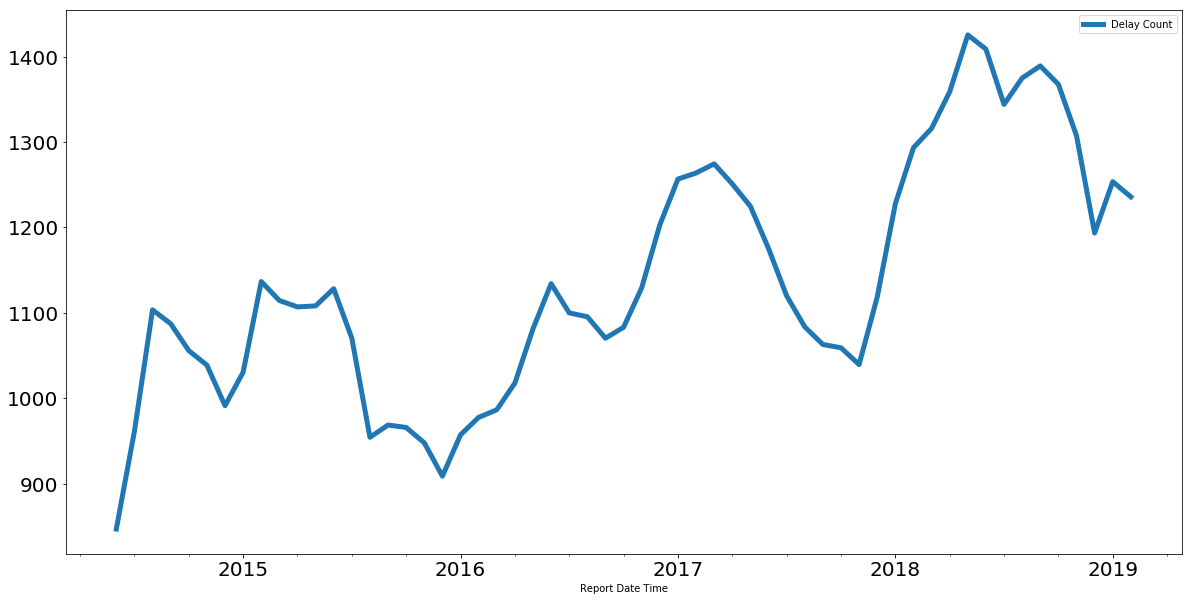

In [43]:
count_delay.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

# Seasonality Analysis

Two examples of seasonality analysis algorithms are:

[Using 1st discrete difference of object](https://machinelearningmastery.com/difference-time-series-dataset-python/)

[Periodicity and Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

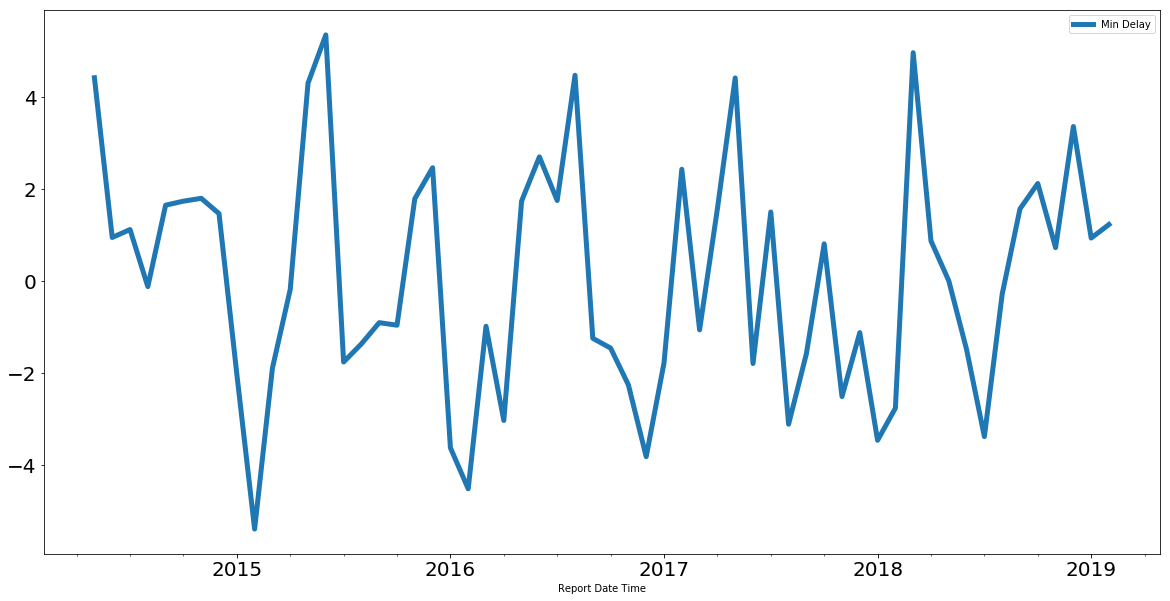

In [44]:
# using 1st discrete difference of object
# This gives us idea about variation of data for a period of time.
mean_delay.diff(periods=4).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

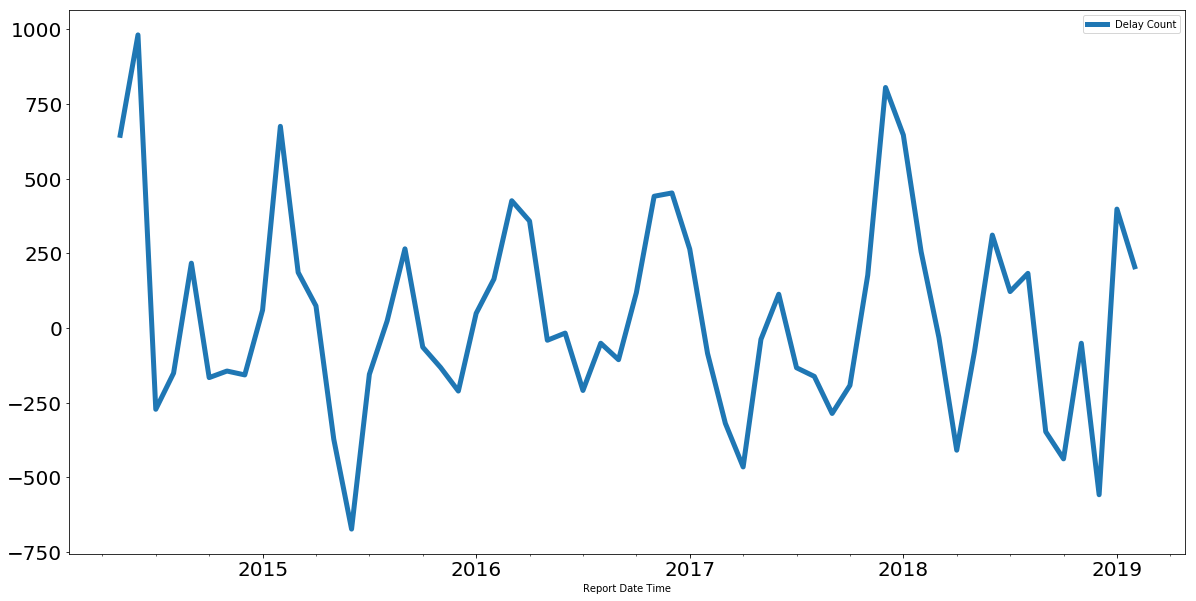

In [45]:
count_delay.diff(periods=4).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

Auto correlation is the most famous way to understand seasonal variation till now. We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.In this plot vertical axis is represented by the following equations:-

> $C_n = \sum_{t = 1}^{n - h} (y(t) - \hat{y}) (y(t + n) - \hat{y}) / n$

> $C_0 = \sum_{t = 1}^{n} (y(t) - \hat{y})^2 / n$

Horizontal axis represents time lag(previous time steps)  h

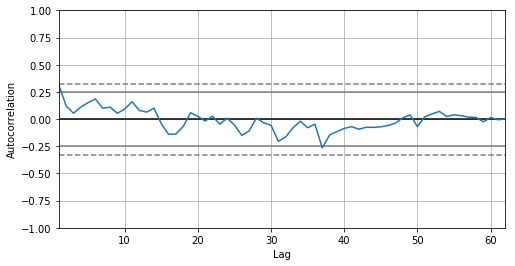

In [46]:
# mean_delay = dfmonthav[['Min Delay']]
# count_delay = dfmonthav[['Delay Count']]


pd.plotting.autocorrelation_plot(dfmonthav['Min Delay'])
plt.show()
# The following curve represents the relation between current time step and its previous time step

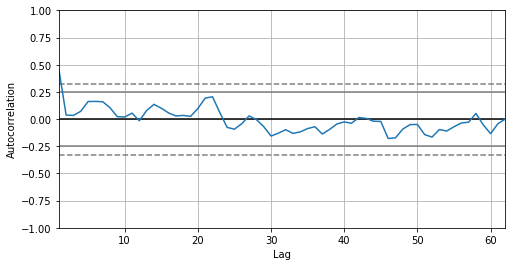

In [47]:
pd.plotting.autocorrelation_plot(dfmonthav['Delay Count'])
plt.show()
# The following curve represents the relation between current time step and its previous time step

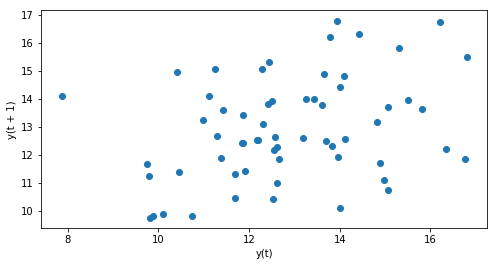

In [48]:
pd.plotting.lag_plot(dfmonthav['Min Delay'])
plt.show()

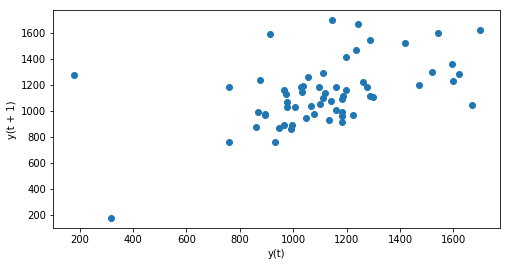

In [49]:
pd.plotting.lag_plot(dfmonthav['Delay Count'])
plt.show()

In [50]:
import pixiedust

Pixiedust database opened successfully



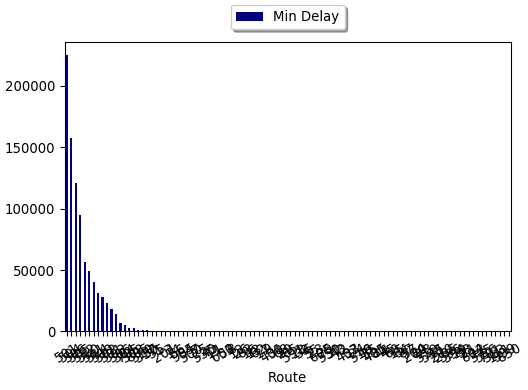

In [ ]:
display(df)